# **Imports and Library Installations**

In [1]:
!pip uninstall -y numpy
!pip install numpy==1.26.4 --upgrade --force-reinstall --quiet

Found existing installation: numpy 2.0.2
Uninstalling numpy-2.0.2:
  Successfully uninstalled numpy-2.0.2
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.0/61.0 kB 3.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 18.3/18.3 MB 78.1 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
thinc 8.3.6 requires numpy<3.0.0,>=2.0.0, but you have numpy 1.26.4 which is incompatible.


In [ ]:
import os
os.kill(os.getpid(), 9)

In [1]:
import numpy as np
print(np.__version__)

2.0.2


In [2]:
#Install dependencies
!pip install pennylane pennylane-lightning

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 57.1/57.1 kB 4.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.3/2.3 MB 25.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.5/2.5 MB 53.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 930.8/930.8 kB 38.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 52.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.6/8.6 MB 74.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 167.9/167.9 kB 11.6 MB/s eta 0:00:00


In [3]:
from google.colab import drive
drive.mount("/content/drive", force_remount = True)

Mounted at /content/drive


In [4]:
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader, Subset

import math
import re
import random
import pandas as pd
import numpy as np
import time
import nltk
from nltk.corpus import stopwords
from nltk.util import ngrams
import matplotlib.pyplot as plt
import pennylane as qml
from collections import Counter

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import PCA

SEED = 42

random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed_all(SEED)

torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

/usr/local/lib/python3.11/dist-packages/pennylane/capture/capture_operators.py:33: RuntimeWarning: PennyLane is not yet compatible with JAX versions > 0.4.28. You have version 0.5.2 installed. Please downgrade JAX to <=0.4.28 to avoid runtime errors.
  warnings.warn(


In [5]:
nltk.download("stopwords")
stop_words = set(stopwords.words("english"))
print(len(stop_words))
domain_neutral_words = {
    "phone", "product", "battery", "headset", "quality", "one", "use"
}
stop_words.update(domain_neutral_words)
print(len(stop_words))

198
205


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


# **Data Loading and Preprocessing**

In [6]:
with open("/content/drive/MyDrive/QML-Research/Data/sentiment labelled sentences/amazon_cells_labelled.txt", "r") as f:
    lines = f.readlines()

sentences = [line.split("\t")[0] for line in lines]
labels = [int(line.split("\t")[1]) for line in lines]

In [7]:
print(f"0 Labels: {labels.count(0)}")
print(f"1 Labels: {labels.count(1)}")

0 Labels: 500
1 Labels: 500


In [8]:
len(sentences)

1000

Sentence Lengths:
min = 11
max = 149
mean = 55.23
95th percentile = 125.04999999999995



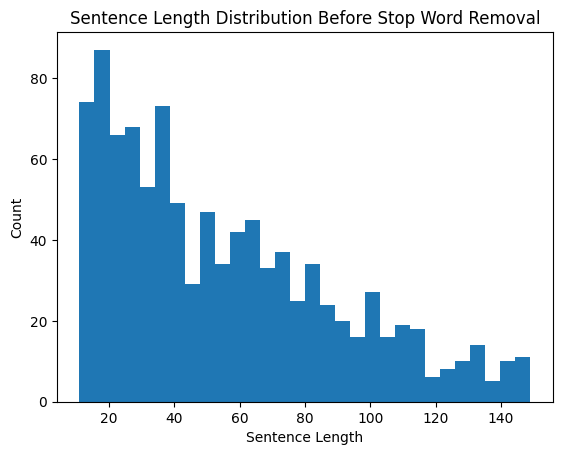

In [9]:
lengths = [len(s) for s in sentences]
print(f"Sentence Lengths:\nmin = {np.min(lengths)}\nmax = {np.max(lengths)}\nmean = {np.mean(lengths):.2f}\n95th percentile = {np.percentile(lengths, 95)}")
print()
plt.hist(lengths, bins = 30)
plt.title("Sentence Length Distribution Before Stop Word Removal")
plt.xlabel("Sentence Length")
plt.ylabel("Count")
plt.show()

In [10]:
def clean_and_tokenize(text):
    text = text.lower()
    text = re.sub(r"http\S+", "", text)
    text = re.sub(r"[^a-z0-9\s]", "", text)
    text = re.sub(r"\s+", " ", text).strip()
    tokens = text.split()
    tokens = [word for word in tokens if word not in stop_words]
    return tokens

cleaned_sents = [clean_and_tokenize(sentence) for sentence in sentences]

# **Padding and Truncation**

In [11]:
max_len = 10
for i in range(len(cleaned_sents)):
  if (len(cleaned_sents[i]) < max_len):
    cleaned_sents[i] += ["<PAD>"] * (max_len - len(cleaned_sents[i]))
  else:
    cleaned_sents[i] = cleaned_sents[i][:max_len]

# **Manual GloVe Embedding**

In [12]:
def load_glove_embeddings(file_path):
    embeddings = {}
    with open(file_path, 'r', encoding='utf-8') as f:
        for line in f:
            values = line.strip().split()
            word = values[0]
            vector = np.array(values[1:], dtype='float32')
            embeddings[word] = vector
    return embeddings

In [13]:
def sentence_to_vec(sentence, embeddings, dim):
    vectors = []
    for word in sentence:
        if word in embeddings:
            vectors.append(embeddings[word])
        else:
            vectors.append(np.zeros(dim))
    return vectors

In [14]:
def embed_sentences(cleaned_sents, embeddings, dim=5):
    return np.array([sentence_to_vec(tokens, embeddings, dim) for tokens in cleaned_sents])

In [15]:
glove_path = '/content/drive/MyDrive/QML-Research/Data/glove.6B.100d.txt'
glove = load_glove_embeddings(glove_path)

# **PCA**

In [16]:
all_words = list(glove.keys())
all_vectors = np.array([glove[word] for word in all_words])
# pca = PCA(n_components=15, random_state=42)
pca = PCA(n_components=5, random_state=42)
reduced_vectors = pca.fit_transform(all_vectors)
reduced_embeddings = {word: reduced_vectors[i] for i, word in enumerate(all_words)}

# **Word Encoding**

In [17]:
# X_embed_np = embed_sentences(cleaned_sents, reduced_embeddings, dim=15)
X_embed_np = embed_sentences(cleaned_sents, reduced_embeddings, dim=5)
X_embed = torch.tensor(X_embed_np).float()
y_embed = torch.tensor(labels).float()

# **DataLoader**

In [18]:
X_train, X_test, y_train, y_test = train_test_split(X_embed, y_embed, test_size=0.2, random_state=42)

In [19]:
class AmazonDataset(Dataset):
    def __init__(self, X, y):
        self.X = X
        self.y = y

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

In [20]:
train_dataset = AmazonDataset(X_train, y_train)
train_loader_small = DataLoader(train_dataset, batch_size=1, shuffle=True)
test_loader = DataLoader(AmazonDataset(X_test, y_test), batch_size=1)

# **Config - 1 (Dense Angle Encoding)**

In [ ]:
n_qubits = 4
dev = qml.device("lightning.qubit", wires=n_qubits, shots=None)

In [ ]:
@qml.qnode(dev, interface="torch")
def quantum_step(inputs, hidden, weights_in, weights_h):
    for i in range(5):
        qml.RY(inputs[i], wires=0)
        qml.RZ(inputs[i] * 0.5, wires=0)

    for i in range(5, 10):
        qml.RY(inputs[i], wires=1)
        qml.RZ(inputs[i] * 0.5, wires=1)

    for i in range(10, 15):
        qml.RY(inputs[i], wires=2)
        qml.RZ(inputs[i] * 0.5, wires=2)

    qml.RY(hidden, wires=3)

    qml.CNOT(wires=[0, 1])
    qml.CNOT(wires=[1, 2])
    qml.CNOT(wires=[2, 3])
    qml.CNOT(wires=[3, 0])

    for i in range(3):
        qml.RY(weights_in[i], wires=i)
        qml.RZ(weights_in[i + 3], wires=i)

    qml.RY(weights_h[0], wires=3)
    return qml.expval(qml.PauliZ(3))

In [ ]:
class QuantumRNN(nn.Module):
    def __init__(self, n_repeats=3):
        super().__init__()
        self.embedding = nn.Linear(15, 15)
        self.weights_in = nn.Parameter(torch.randn(6) * 0.1)
        self.weights_h = nn.Parameter(torch.randn(1) * 0.1)
        self.classifier = nn.Linear(1, 1)
        self.n_repeats = n_repeats

    def forward(self, x):
        seq_len = x.shape[0]
        hidden = torch.tensor(0.0, dtype=torch.float32, requires_grad=True)

        for t in range(seq_len):
            input_t = self.embedding(x[t])
            for _ in range(self.n_repeats):
                hidden = quantum_step(input_t, hidden, self.weights_in, self.weights_h).float()

        out = self.classifier(hidden.unsqueeze(0))
        return out

# **Config - 2 (Angle Encoding)**

In [21]:
n_qubits = 6
dev = qml.device("lightning.qubit", wires=n_qubits, shots=None)

In [22]:
@qml.qnode(dev, interface="torch")
def quantum_step(inputs, hidden, weights_in, weights_h):
    inputs_norm = inputs / (torch.norm(inputs) + 1e-8)

    for i in range(5):
        qml.RY(inputs_norm[i], wires=i)

    qml.RY(hidden, wires=5)

    for i in range(5):
        qml.CNOT(wires=[i, (i + 1) % 5])

    for i in range(5):
        qml.RY(weights_in[i], wires=i)

    qml.RY(weights_h[0], wires=5)
    return qml.expval(qml.PauliZ(5))

In [ ]:
class QuantumRNN(nn.Module):
    def __init__(self, n_repeats=3):
        super().__init__()
        self.embedding = nn.Linear(5, 5)
        self.weights_in = nn.Parameter(torch.randn(5) * 0.1)
        self.weights_h = nn.Parameter(torch.randn(1) * 0.1)
        self.classifier = nn.Linear(1, 1)
        self.n_repeats = n_repeats

    def forward(self, x):
        seq_len = x.shape[0]
        hidden = torch.tensor(0.0, dtype=torch.float32, requires_grad=True)

        for t in range(seq_len):
            input_t = self.embedding(x[t])
            for _ in range(self.n_repeats):
                hidden = quantum_step(input_t, hidden, self.weights_in, self.weights_h).float()

        out = self.classifier(hidden.unsqueeze(0))
        return out

In [26]:
start_time = time.time()
epochs = 50
model.train()

for epoch in range(epochs):
    total_loss = 0
    correct = 0
    total = 0
    epoch_start = time.time()

    for xb, yb in train_loader_small:
        xb = xb.squeeze(0)
        yb = yb.squeeze()

        optimizer.zero_grad()
        output = model(xb)

        output_flat = output.squeeze()
        yb_flat = yb.float()

        loss = loss_fn(output_flat, yb_flat)
        loss.backward()
        optimizer.step()

        total_loss += loss.item()
        predicted = (torch.sigmoid(output_flat) > 0.5).float()
        correct += (predicted == yb_flat).sum().item()
        total += 1

    avg_loss = total_loss / len(train_loader_small)
    epoch_time = time.time() - epoch_start
    accuracy = 100 * correct / total
    print(f"Epoch {epoch+1}, Loss: {avg_loss:.4f}, Accuracy: {accuracy:.2f}%")
    print(f"Time for epoch: {epoch_time:.2f} seconds")

total_time = time.time() - start_time
print(f"\nTotal training time: {total_time:.2f} seconds")

Epoch 1, Loss: 0.7121, Accuracy: 48.50%
Time for epoch: 161.49 seconds
Epoch 2, Loss: 0.6959, Accuracy: 46.88%
Time for epoch: 162.12 seconds
Epoch 3, Loss: 0.6962, Accuracy: 48.38%
Time for epoch: 160.49 seconds
Epoch 4, Loss: 0.6962, Accuracy: 50.62%
Time for epoch: 163.64 seconds
Epoch 5, Loss: 0.6957, Accuracy: 48.62%
Time for epoch: 161.13 seconds
Epoch 6, Loss: 0.6958, Accuracy: 48.12%
Time for epoch: 171.93 seconds
Epoch 7, Loss: 0.6937, Accuracy: 52.25%
Time for epoch: 166.20 seconds
Epoch 8, Loss: 0.6956, Accuracy: 46.38%
Time for epoch: 168.20 seconds
Epoch 9, Loss: 0.6960, Accuracy: 47.38%
Time for epoch: 165.76 seconds
Epoch 10, Loss: 0.6939, Accuracy: 51.50%
Time for epoch: 164.85 seconds
Epoch 11, Loss: 0.6956, Accuracy: 44.88%
Time for epoch: 169.14 seconds
Epoch 12, Loss: 0.6953, Accuracy: 49.38%
Time for epoch: 167.35 seconds
Epoch 13, Loss: 0.6948, Accuracy: 49.25%
Time for epoch: 167.70 seconds
Epoch 14, Loss: 0.6948, Accuracy: 47.75%
Time for epoch: 164.39 seconds
E

In [27]:
model.eval()
correct = 0
total = 0
with torch.no_grad():
    for xb, yb in test_loader:
        xb = xb.squeeze(0)
        yb = yb.squeeze()

        logits = model(xb)
        logits_flat = logits.squeeze()
        prob = torch.sigmoid(logits_flat)
        pred = (prob > 0.5).float()
        actual = yb.float()

        if pred == actual:
            correct += 1
        total += 1

        if total <= 10:
            print(f"Logit: {logits_flat.item():.3f} | Probability: {prob.item():.3f} | Pred: {pred.item()}, Actual: {actual.item()}")

print(f"Test Accuracy: {correct / total * 100:.2f}%")

Logit: -0.032 | Probability: 0.492 | Pred: 0.0, Actual: 1.0
Logit: -0.032 | Probability: 0.492 | Pred: 0.0, Actual: 1.0
Logit: -0.032 | Probability: 0.492 | Pred: 0.0, Actual: 1.0
Logit: -0.032 | Probability: 0.492 | Pred: 0.0, Actual: 0.0
Logit: -0.032 | Probability: 0.492 | Pred: 0.0, Actual: 1.0
Logit: -0.032 | Probability: 0.492 | Pred: 0.0, Actual: 1.0
Logit: -0.032 | Probability: 0.492 | Pred: 0.0, Actual: 0.0
Logit: -0.032 | Probability: 0.492 | Pred: 0.0, Actual: 1.0
Logit: -0.032 | Probability: 0.492 | Pred: 0.0, Actual: 0.0
Logit: -0.032 | Probability: 0.492 | Pred: 0.0, Actual: 1.0
Test Accuracy: 46.50%


# **Model Initialization**

In [ ]:
# Dense Angle Encoding
model = QuantumRNN(n_repeats=2)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
loss_fn = nn.BCEWithLogitsLoss()

In [24]:
# Angle Encoding
model = QuantumRNN(n_repeats=3)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
loss_fn = nn.BCEWithLogitsLoss()

In [25]:
for name, param in model.named_parameters():
    print(f"{name}: {param.shape}")

weights_in: torch.Size([5])
weights_h: torch.Size([1])
embedding.weight: torch.Size([5, 5])
embedding.bias: torch.Size([5])
classifier.weight: torch.Size([1, 1])
classifier.bias: torch.Size([1])


# **Training Loop**

In [ ]:
start_time = time.time()
epochs = 50
model.train()

for epoch in range(epochs):
    total_loss = 0
    correct = 0
    total = 0
    epoch_start = time.time()

    for xb, yb in train_loader_small:
        xb = xb.squeeze(0)
        yb = yb.squeeze()

        optimizer.zero_grad()
        output = model(xb)

        output_flat = output.squeeze()
        yb_flat = yb.float()

        loss = loss_fn(output_flat, yb_flat)
        loss.backward()
        optimizer.step()

        total_loss += loss.item()
        predicted = (torch.sigmoid(output_flat) > 0.5).float()
        correct += (predicted == yb_flat).sum().item()
        total += 1

    avg_loss = total_loss / len(train_loader_small)
    epoch_time = time.time() - epoch_start
    accuracy = 100 * correct / total
    print(f"Epoch {epoch+1}, Loss: {avg_loss:.4f}, Accuracy: {accuracy:.2f}%")
    print(f"Time for epoch: {epoch_time:.2f} seconds")

total_time = time.time() - start_time
print(f"\nTotal training time: {total_time:.2f} seconds")

Epoch 1, Loss: 0.7015, Accuracy: 48.25%
Time for epoch: 197.81 seconds
Epoch 2, Loss: 0.6986, Accuracy: 49.88%
Time for epoch: 195.32 seconds
Epoch 3, Loss: 0.6981, Accuracy: 46.75%
Time for epoch: 200.33 seconds
Epoch 4, Loss: 0.6964, Accuracy: 50.88%
Time for epoch: 200.70 seconds
Epoch 5, Loss: 0.6965, Accuracy: 50.50%
Time for epoch: 202.60 seconds
Epoch 6, Loss: 0.6957, Accuracy: 48.12%
Time for epoch: 198.51 seconds
Epoch 7, Loss: 0.6942, Accuracy: 51.88%
Time for epoch: 198.62 seconds
Epoch 8, Loss: 0.6944, Accuracy: 50.50%
Time for epoch: 196.29 seconds
Epoch 9, Loss: 0.6955, Accuracy: 47.75%
Time for epoch: 197.40 seconds
Epoch 10, Loss: 0.6947, Accuracy: 48.12%
Time for epoch: 197.67 seconds
Epoch 11, Loss: 0.6952, Accuracy: 48.25%
Time for epoch: 198.07 seconds
Epoch 12, Loss: 0.6940, Accuracy: 48.38%
Time for epoch: 200.97 seconds
Epoch 13, Loss: 0.6956, Accuracy: 48.62%
Time for epoch: 198.37 seconds
Epoch 14, Loss: 0.6949, Accuracy: 48.00%
Time for epoch: 197.99 seconds
E

# **Testing Loop**

In [ ]:
model.eval()
correct = 0
total = 0
with torch.no_grad():
    for xb, yb in test_loader:
        xb = xb.squeeze(0)
        yb = yb.squeeze()

        logits = model(xb)
        logits_flat = logits.squeeze()
        prob = torch.sigmoid(logits_flat)
        pred = (prob > 0.5).float()
        actual = yb.float()

        if pred == actual:
            correct += 1
        total += 1

        if total <= 10:
            print(f"Logit: {logits_flat.item():.3f} | Probability: {prob.item():.3f} | Pred: {pred.item()}, Actual: {actual.item()}")

print(f"Test Accuracy: {correct / total * 100:.2f}%")

Logit: 0.105 | Probability: 0.526 | Pred: 1.0, Actual: 1.0
Logit: 0.108 | Probability: 0.527 | Pred: 1.0, Actual: 1.0
Logit: 0.108 | Probability: 0.527 | Pred: 1.0, Actual: 1.0
Logit: 0.085 | Probability: 0.521 | Pred: 1.0, Actual: 0.0
Logit: 0.106 | Probability: 0.527 | Pred: 1.0, Actual: 1.0
Logit: 0.105 | Probability: 0.526 | Pred: 1.0, Actual: 1.0
Logit: 0.099 | Probability: 0.525 | Pred: 1.0, Actual: 0.0
Logit: 0.098 | Probability: 0.525 | Pred: 1.0, Actual: 1.0
Logit: 0.107 | Probability: 0.527 | Pred: 1.0, Actual: 0.0
Logit: 0.107 | Probability: 0.527 | Pred: 1.0, Actual: 1.0
Test Accuracy: 53.50%
